In [57]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import scipy.stats as stats
import datetime
import re
import itertools
from plotly.offline import init_notebook_mode, iplot
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import spacy 
from collections import Counter


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from warnings import filterwarnings
filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/ted-join-expand/ted_expanded.csv
/kaggle/input/ted-joined/ted_full.csv
/kaggle/input/ted-talks/ted_main.csv
/kaggle/input/ted-talks/transcripts.csv


In [58]:
df= pd.read_csv('../input/ted-joined/ted_full.csv')
data=df.copy()
df.shape

(2553, 18)

2553 rows

In [59]:
# taking tags that have occurred more than 180 times to create columns
count_vector = CountVectorizer(stop_words='english',min_df=180/len(data)) 
tag_array = count_vector.fit_transform(data.tags).toarray()
tag_matrix = pd.DataFrame(tag_array, columns = count_vector.get_feature_names())
tag_matrix = tag_matrix.add_prefix('tags_')

# append the columns obtained to the base data
data = pd.concat([data,tag_matrix], axis=1)
data=data.drop(['tags'], axis = 1) # drop tags column
#list(data)

In [60]:
data.head()

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,...,tags_health,tags_humanity,tags_innovation,tags_issues,tags_science,tags_social,tags_society,tags_technology,tags_ted,tags_tedx
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1.140826e+09,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,...,0,0,0,0,0,0,0,0,0,0
1,265,With the same humor and humanity he exuded in ...,977,TED2006,1.140826e+09,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,...,0,0,0,1,1,0,0,1,0,0
2,124,New York Times columnist David Pogue takes aim...,1286,TED2006,1.140739e+09,26,David Pogue,David Pogue: Simplicity sells,1,1151367060,...,0,0,0,0,0,0,0,1,0,0
3,200,"In an emotionally charged talk, MacArthur-winn...",1116,TED2006,1.140912e+09,35,Majora Carter,Majora Carter: Greening the ghetto,1,1151367060,...,0,0,0,0,0,0,0,0,0,0
4,593,You've never seen data presented like this. Wi...,1190,TED2006,1.140566e+09,48,Hans Rosling,Hans Rosling: The best stats you've ever seen,1,1151440680,...,1,0,0,1,0,0,0,0,0,0


In [61]:
# all date operations
data['film_date'] = data['film_date'].apply(lambda x: datetime.date.fromtimestamp(int(x)))
data['published_date'] = data['published_date'].apply(lambda x: datetime.date.fromtimestamp(int(x)))
data['film_month'] = data['film_date'].apply(lambda x: x.month)
data['pub_month'] = data['published_date'].apply(lambda x: x.month)
data['film_weekday'] = data['film_date'].apply(lambda x: x.weekday()) # Monday: 0, Sunday: 6
data['pub_weekday'] = data['published_date'].apply(lambda x: x.weekday())
data[['film_date','published_date']].head()

,film_date,published_date
0,2006-02-25,2006-06-27
1,2006-02-25,2006-06-27
2,2006-02-24,2006-06-27
3,2006-02-26,2006-06-27
4,2006-02-22,2006-06-27


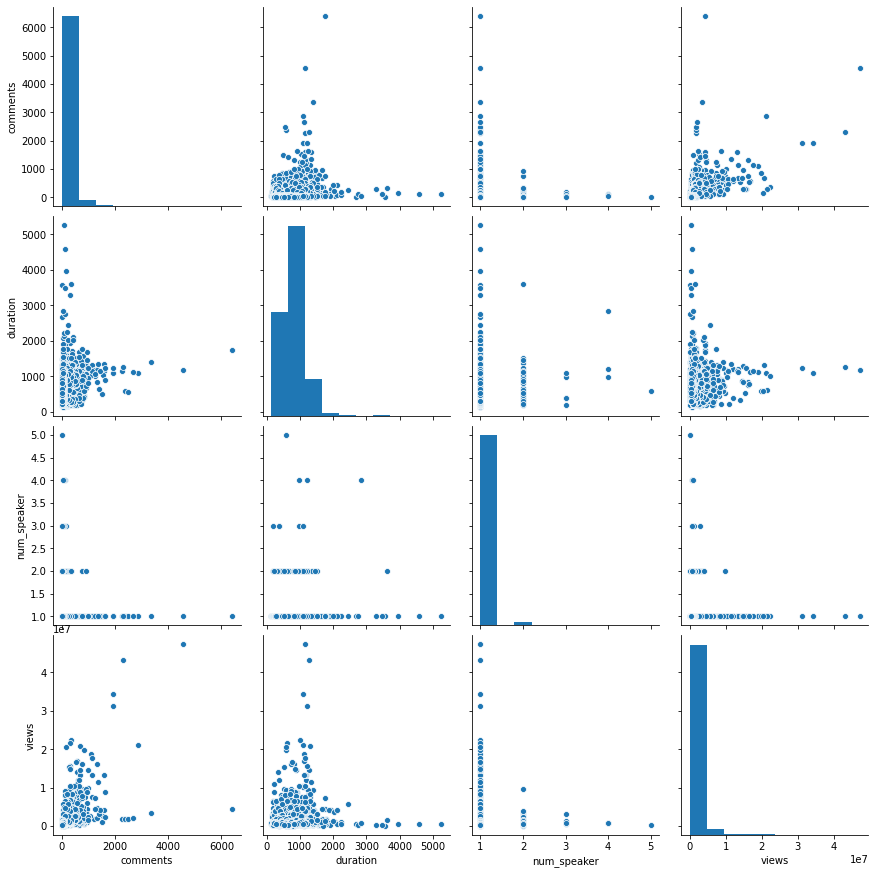

In [62]:
# pairplots between numerical variables to check for evident patterns and correlations
nums = ['comments', 'duration', 'num_speaker', 'views']
sns.pairplot(data, vars=nums,   size=3);

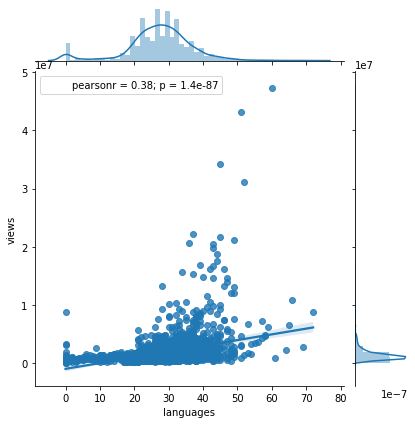

In [63]:
sns.jointplot(x=data['languages'], y=data['views'], kind='reg').annotate(stats.pearsonr)

There are a few videos which have high views despite common languages. These may be outliers which have high views due to some other factors. We will have to investigate those.

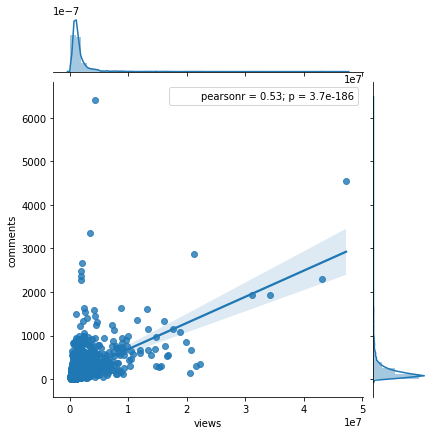

In [64]:
sns.jointplot(x=data['views'], y=data['comments'], kind='reg').annotate(stats.pearsonr)

There seems to be a very high correlation between comments and views as it is intuitive.

In [65]:
# check relation between duration, comments and views
data_sorted=data.sort_values(by='views',ascending=True)
df2=data_sorted.iloc[:20,:]
df2.index=range(0,len(df2))
#visualization
data_viz = [
    {
        'y': df2.views,
        'x': df2.index,
        'mode': 'markers',
        'marker': {
            'color': df2.duration,
            'size': df2.comments,
            'showscale': True
        },
        "text" :  df2.main_speaker    
    }
]
iplot(data_viz)

Clearly, there are a few videos which have a low views and longer. This may be an important factor for the model

In [66]:
data['event'].unique()
    
data['event_category'] = data.event.apply(lambda x: "TEDx" if "TEDx" in x else ("TED" if "TED" in x else "Other"))

In [67]:
data['event_category'].value_counts()

TED      1971
TEDx      471
Other     111
Name: event_category, dtype: int64

In [68]:
data['duration']= data['duration']/60 # per minute
data['transcript'] = data['transcript'].fillna('')
data['wc_per_min'] = data['transcript'].apply(lambda x: len(x.split()))/data['duration']

In [69]:
data.head()

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,...,tags_society,tags_technology,tags_ted,tags_tedx,film_month,pub_month,film_weekday,pub_weekday,event_category,wc_per_min
0,4553,Sir Ken Robinson makes an entertaining and pro...,19.400000,TED2006,2006-02-25,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,2006-06-27,...,0,0,0,0,2,6,5,1,TED,158.041237
1,265,With the same humor and humanity he exuded in ...,16.283333,TED2006,2006-02-25,43,Al Gore,Al Gore: Averting the climate crisis,1,2006-06-27,...,0,1,0,0,2,6,5,1,TED,128.290686
2,124,New York Times columnist David Pogue takes aim...,21.433333,TED2006,2006-02-24,26,David Pogue,David Pogue: Simplicity sells,1,2006-06-27,...,0,1,0,0,2,6,4,1,TED,151.772939
3,200,"In an emotionally charged talk, MacArthur-winn...",18.600000,TED2006,2006-02-26,35,Majora Carter,Majora Carter: Greening the ghetto,1,2006-06-27,...,0,0,0,0,2,6,6,1,TED,162.096774
4,593,You've never seen data presented like this. Wi...,19.833333,TED2006,2006-02-22,48,Hans Rosling,Hans Rosling: The best stats you've ever seen,1,2006-06-27,...,0,0,0,0,2,6,2,1,TED,157.361345


In [70]:
data.shape

(2553, 45)

In [76]:
nlp = spacy.load('en')

feats = ['char_count', 'word_count', 'word_count_cln',
       'stopword_count', '_NOUN', '_VERB', '_ADP', '_ADJ', '_DET', '_PROPN',
       '_INTJ', '_PUNCT', '_NUM', '_PRON', '_ADV', '_PART', '_amod', '_advmod', '_acl', '_relcl', '_advcl',
       '_neg','_PERSON','_NORP','_FAC','_ORG','_GPE','_LOC','_PRODUCT','_EVENT','_WORK_OF_ART','_LANGUAGE']

class text_features:
    def __init__(self, df, textcol):
        self.df = df
        self.textcol = textcol
        self.c = "spacy_" + textcol
        self.df[self.c] = self.df[self.textcol].apply( lambda x : nlp(x))
        
        self.pos_tags = ['NOUN', 'VERB', 'ADP', 'ADJ', 'DET', 'PROPN', 'INTJ', 'PUNCT',\
                         'NUM', 'PRON', 'ADV', 'PART']
        self.dep_tags = ['amod', 'advmod', 'acl', 'relcl', 'advcl','neg']
        self.ner_tags = ['PERSON','NORP','FAC','ORG','GPE','LOC','PRODUCT','EVENT','WORK_OF_ART','LANGUAGE']
        
    def _spacy_cleaning(self, doc):
        tokens = [token for token in doc if (token.is_stop == False)\
                  and (token.is_punct == False)]
        words = [token.lemma_ for token in tokens]
        return " ".join(words)
        
    def _spacy_features(self):
        self.df["clean_text"] = self.df[self.c].apply(lambda x : self._spacy_cleaning(x))
        self.df["char_count"] = self.df[self.textcol].apply(len)
        self.df["word_count"] = self.df[self.c].apply(lambda x : len([_ for _ in x]))
        self.df["word_count_cln"] = self.df["clean_text"].apply(lambda x : len(x.split()))
        
        self.df["stopword_count"] = self.df[self.c].apply(lambda x : 
                                                          len([_ for _ in x if _.is_stop]))
        self.df["pos_tags"] = self.df[self.c].apply(lambda x :
                                                    dict(Counter([_.head.pos_ for _ in x])))
        self.df["dep_tags"] = self.df[self.c].apply(lambda x :
                                                    dict(Counter([_.dep_ for _ in x])))
        self.df["ner_tags"] = self.df[self.c].apply(lambda x :
                                                    dict(Counter([_.ent_type_ for _ in x])))
        
    def _flatten_features(self):
        for key in self.pos_tags:
            self.df["_" + key] = self.df["pos_tags"].apply(lambda x : \
                                                           x[key] if key in x else 0)
        
        for key in self.dep_tags:
            self.df["_" + key] = self.df["dep_tags"].apply(lambda x : \
                                                           x[key] if key in x else 0)
            
        for key in self.ner_tags:
            self.df["_" + key] = self.df["ner_tags"].apply(lambda x : \
                                                           x[key] if key in x else 0)
                
    def generate_features(self):
        self._spacy_features()
        self._flatten_features()
        self.df = self.df.drop([self.c, "pos_tags", "dep_tags", 'ner_tags',"clean_text"], axis=1)
        return self.df
    
    
def spacy_features(df, tc):
    fe = text_features(df, tc)
    return fe.generate_features()

In [77]:
textcol = "transcript"
transcript_features = spacy_features(data, textcol)
transcript_features[[textcol] + feats].head()

,transcript,char_count,word_count,word_count_cln,stopword_count,_NOUN,_VERB,_ADP,_ADJ,_DET,...,_PERSON,_NORP,_FAC,_ORG,_GPE,_LOC,_PRODUCT,_EVENT,_WORK_OF_ART,_LANGUAGE
0,Good morning. How are you?(Laughter)It's been ...,17409,3798,1190,2032,735,1575,311,49,7,...,37,0,0,24,16,6,1,0,11,1
1,"Thank you so much, Chris. And it's truly a gre...",11814,2482,855,1298,566,1061,213,45,26,...,33,6,2,11,30,5,3,0,0,0
2,"(Music: ""The Sound of Silence,"" Simon & Garfun...",18309,4046,1351,2048,798,1796,215,87,11,...,35,3,0,54,6,1,4,0,19,0
3,If you're here today — and I'm very happy that...,18249,3598,1443,1703,1058,1255,319,113,12,...,24,1,6,21,32,50,1,0,0,0
4,"About 10 years ago, I took on the task to teac...",17365,3707,1215,1984,801,1335,269,73,3,...,15,18,0,31,80,49,2,0,5,0


In [78]:
data['transcript'].str.count("(Laughter)")
data['transcript'].str.count("(Applause)")

0        4
1        6
2       12
3        7
4        4
        ..
2548     1
2549     1
2550     1
2551     7
2552     1
Name: transcript, Length: 2553, dtype: int64

In [80]:
data['laughter_count']=data['transcript'].str.count("(Laughter)")
data['applaud_count']=data['transcript'].str.count("(Applause)")
data.head()

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,...,_NORP,_FAC,_ORG,_GPE,_LOC,_PRODUCT,_EVENT,_WORK_OF_ART,_LANGUAGE,laughter_count
0,4553,Sir Ken Robinson makes an entertaining and pro...,19.400000,TED2006,2006-02-25,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,2006-06-27,...,0,0,24,16,6,1,0,11,1,39
1,265,With the same humor and humanity he exuded in ...,16.283333,TED2006,2006-02-25,43,Al Gore,Al Gore: Averting the climate crisis,1,2006-06-27,...,6,2,11,30,5,3,0,0,0,22
2,124,New York Times columnist David Pogue takes aim...,21.433333,TED2006,2006-02-24,26,David Pogue,David Pogue: Simplicity sells,1,2006-06-27,...,3,0,54,6,1,4,0,19,0,38
3,200,"In an emotionally charged talk, MacArthur-winn...",18.600000,TED2006,2006-02-26,35,Majora Carter,Majora Carter: Greening the ghetto,1,2006-06-27,...,1,6,21,32,50,1,0,0,0,10
4,593,You've never seen data presented like this. Wi...,19.833333,TED2006,2006-02-22,48,Hans Rosling,Hans Rosling: The best stats you've ever seen,1,2006-06-27,...,18,0,31,80,49,2,0,5,0,10
